# Homework 6 - Convolutional Neural Networks

In this assignment, you will learn how to implement a convolutional neural network (CNN) from scratch using numpy. You will derive the derivatives yourself, implement forward and backward propagation for convolutional layers, pooling layers, and fully connected layers, and visualize the learned filters. (However, instead of using a fixed learning rate, we will call TensorFlow's implementation of Adam optimization to speed up training)

## Task 1: Load and Visualize the MNIST Data

First, let's load a subset of the MNIST dataset and visualize it. We will use this dataset to train our CNN.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


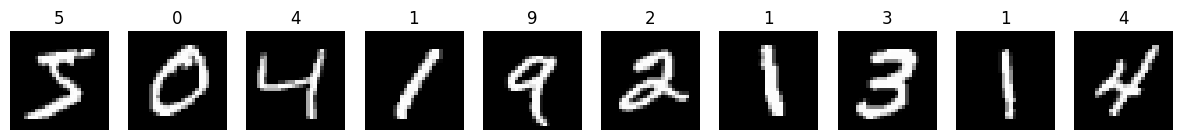

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf


# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data to include channel dimension
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Use a smaller subset of the data for faster training
x_train, y_train = x_train[:100], y_train[:100]
x_test, y_test = x_test[:200], y_test[:200]

# Visualize some samples from the dataset
def visualize_mnist_samples(X, y):
    fig, axes = plt.subplots(1, 10, figsize=(15, 15))
    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(np.argmax(y[i]))
        ax.axis('off')
    plt.show()

visualize_mnist_samples(x_train, y_train)

## Task 2: Implement Convolutional Layers

### Step 1: Implement the Convolution Operation

Implement the function to perform the convolution operation.

In [2]:
def conv_forward(X, W, b, stride=1, padding=1):
    (n_H_prev, n_W_prev, n_C_prev) = X.shape
    (f, f, n_C_prev, n_C) = W.shape
    n_H = int((n_H_prev - f + 2 * padding) / stride) + 1
    n_W = int((n_W_prev - f + 2 * padding) / stride) + 1
    Z = np.zeros((n_H, n_W, n_C))

    X_pad = np.pad(X, ((padding, padding), (padding, padding), (0, 0)), 'constant')

    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                vert_start = h * stride
                vert_end = vert_start + f
                horiz_start = w * stride
                horiz_end = horiz_start + f
                X_slice = X_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                Z[h, w, c] = np.sum(X_slice * W[:, :, :, c]) + b[:, :, :, c]

    return Z


### Step 2: Implement the ReLU Activation Function

Implement the ReLU activation function.

In [3]:
def relu(Z):
    return np.maximum(0, Z)

### Step 3: Implement the Max Pooling Layer (1 pt)

Implement the function to perform max pooling.

In [5]:
def pool_forward(A_prev, f=2, stride=2):
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    A = np.zeros((n_H, n_W, n_C_prev))

    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C_prev):
                vert_start = h * stride
                vert_end = vert_start + f
                horiz_start = w * stride
                horiz_end = horiz_start + f
                A[h, w, c] = np.max(A_prev[vert_start:vert_end, horiz_start:horiz_end, c])

    return A


## Task 3: Implement Fully Connected Layers

### Step 1: Implement the Flatten Layer

Implement the function to flatten the input.

In [6]:
def flatten(X):
    return X.flatten().reshape(1, -1)

### Step 2: Implement the Fully Connected Layer

Implement the function for the fully connected layer.

In [7]:
def fc_forward(X, W, b):
    return np.dot(X, W) + b

### Step 3: Implement the Softmax Activation Function

Implement the softmax function.

In [8]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))
    return exp_Z / np.sum(exp_Z)

## Task 4: Implement the Forward Propagation

Implement the forward propagation step.

In [9]:
def forward_propagation(X, params):
    (W1, b1, W2, b2, W3, b3) = params

    #Describe the computation structure of the CNN model
    Z1 = conv_forward(X, W1, b1)
    A1 = relu(Z1)
    P1 = pool_forward(A1)
    F1 = flatten(P1)
    Z2 = fc_forward(F1, W2, b2)
    A2 = relu(Z2)
    Z3 = fc_forward(A2, W3, b3)
    A3 = softmax(Z3)

    return Z1, A1, P1, F1, Z2, A2, Z3, A3

## Task 5: Compute the Loss

Implement the function to compute the cross-entropy loss.

In [10]:
def compute_loss(y, y_pred):
    return -np.log(y_pred[0, y])

## Task 6: Implement the Backward Propagation

Compute the gradients using backward propagation.

In [11]:
def backward_propagation(X, y, params, cache):
    (W1, b1, W2, b2, W3, b3) = params
    (Z1, A1, P1, F1, Z2, A2, Z3, A3) = cache

    dZ3 = A3
    dZ3[0, y] -= 1
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)
    dA2 = np.dot(dZ3, W3.T)

    dZ2 = dA2 * (Z2 > 0)
    dW2 = np.dot(F1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dF1 = np.dot(dZ2, W2.T)

    dP1 = dF1.reshape(P1.shape)
    dA1 = np.zeros_like(A1)
    for h in range(P1.shape[0]):
        for w in range(P1.shape[1]):
            for c in range(P1.shape[2]):
                vert_start = h * 2
                vert_end = vert_start + 2
                horiz_start = w * 2
                horiz_end = horiz_start + 2
                mask = (A1[vert_start:vert_end, horiz_start:horiz_end, c] == np.max(A1[vert_start:vert_end, horiz_start:horiz_end, c]))
                dA1[vert_start:vert_end, horiz_start:horiz_end, c] += mask * dP1[h, w, c]

    dZ1 = dA1 * (Z1 > 0)
    dW1 = np.zeros_like(W1)
    db1 = np.zeros_like(b1)
    X_pad = np.pad(X, ((1, 1), (1, 1), (0, 0)), 'constant')
    for h in range(dZ1.shape[0]):
        for w in range(dZ1.shape[1]):
            for c in range(dZ1.shape[2]):
                vert_start = h * 1
                vert_end = vert_start + W1.shape[0]
                horiz_start = w * 1
                horiz_end = horiz_start + W1.shape[1]
                dW1[:, :, :, c] += dZ1[h, w, c] * X_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                db1[:, :, :, c] += dZ1[h, w, c]

    return dW1, db1, dW2, db2, dW3, db3

## Task 7: Update Parameters Using Gradient Descent

Update the parameters using gradient descent.

In [12]:
def update_parameters(params, grads, learning_rate):
    (W1, b1, W2, b2, W3, b3) = params
    (dW1, db1, dW2, db2, dW3, db3) = grads

    # Convert NumPy arrays to TensorFlow variables
    W1 = tf.Variable(W1)
    b1 = tf.Variable(b1)
    W2 = tf.Variable(W2)
    b2 = tf.Variable(b2)
    W3 = tf.Variable(W3)
    b3 = tf.Variable(b3)

    optimizer.apply_gradients(zip([dW1, db1, dW2, db2, dW3, db3], [W1, b1, W2, b2, W3, b3]))

    # Convert TensorFlow variables back to NumPy arrays for consistency
    W1 = W1.numpy()
    b1 = b1.numpy()
    W2 = W2.numpy()
    b2 = b2.numpy()
    W3 = W3.numpy()
    b3 = b3.numpy()

    #W1 -= learning_rate * dW1
    #b1 -= learning_rate * db1
    #W2 -= learning_rate * dW2
    #b2 -= learning_rate * db2
    #W3 -= learning_rate * dW3
    #b3 -= learning_rate * db3

    return W1, b1, W2, b2, W3, b3

## Task 8: Train the Model

Train the model using gradient descent (with Adam optimization) and plot the loss over iterations.

<ipython-input-2-89709a2af507>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[h, w, c] = np.sum(X_slice * W[:, :, :, c]) + b[:, :, :, c]


Iteration 0: Loss = 230.2617107752144
Iteration 1: Loss = 229.5248364596287
Iteration 2: Loss = 222.95291962999062
Iteration 3: Loss = 207.208246067131
Iteration 4: Loss = 182.37067347743118
Iteration 5: Loss = 148.9461666135724
Iteration 6: Loss = 145.99463211437805
Iteration 7: Loss = 135.27252052242235
Iteration 8: Loss = 119.53513185562568
Iteration 9: Loss = 111.44066421297269
Iteration 10: Loss = 98.98291075581086
Iteration 11: Loss = 99.21221376660549
Iteration 12: Loss = 87.66154187482398
Iteration 13: Loss = 88.59188937328139
Iteration 14: Loss = 73.06703366433213
Iteration 15: Loss = 81.8091446712278
Iteration 16: Loss = 66.89382075490425
Iteration 17: Loss = 83.09952330792639
Iteration 18: Loss = 60.25588725363192
Iteration 19: Loss = 82.79499092872382
Iteration 20: Loss = 52.35144130583416
Iteration 21: Loss = 74.77150662027081
Iteration 22: Loss = 49.512990017628624
Iteration 23: Loss = 68.21102359017489
Iteration 24: Loss = 41.57148912476719
Iteration 25: Loss = 57.591921

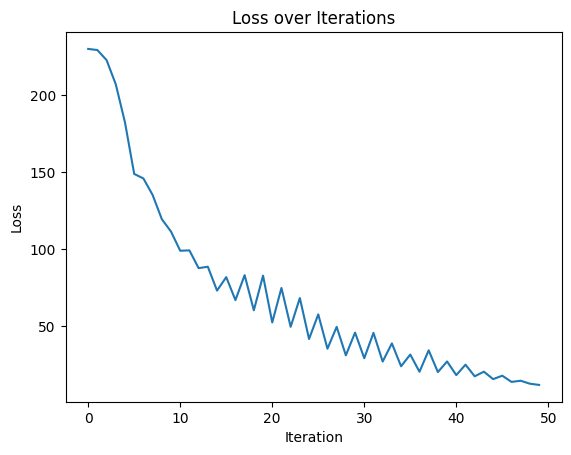

In [18]:
def initialize_parameters_conv(filter_shape):
    W = np.random.randn(*filter_shape) * 0.01
    b = np.zeros((1, 1, 1, filter_shape[3]))
    return W, b

def initialize_parameters_fc(shape):
    W = np.random.randn(shape[0], shape[1]) * 0.01
    b = np.zeros((1, shape[1]))
    return W, b

input_dim = (28, 28, 1)
conv_dim = (3, 3, 1, 8)
fc1_dim = (8 * 14 * 14, 100)
fc2_dim = (100, 10)
W1, b1 = initialize_parameters_conv(conv_dim)
W2, b2 = initialize_parameters_fc(fc1_dim)
W3, b3 = initialize_parameters_fc(fc2_dim)

# Train the model
num_iterations = 50
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_history = []

for i in range(num_iterations):
    loss = 0

    grad_dW1 = np.zeros_like(W1)
    grad_db1 = np.zeros_like(b1)
    grad_dW2 = np.zeros_like(W2)
    grad_db2 = np.zeros_like(b2)
    grad_dW3 = np.zeros_like(W3)
    grad_db3 = np.zeros_like(b3)

    params = (W1, b1, W2, b2, W3, b3)

    for j in range(len(x_train)):
        X = x_train[j]
        y = np.argmax(y_train[j])

        # Forward propagation
        Z1, A1, P1, F1, Z2, A2, Z3, A3 = forward_propagation(X, params)
        cache = (Z1, A1, P1, F1, Z2, A2, Z3, A3)

        # Compute loss
        loss += compute_loss(y, A3)

        # Backward propagation
        dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X, y, params, cache)

        # Accumulate gradients across training examples
        grad_dW1 += dW1
        grad_db1 += db1
        grad_dW2 += dW2
        grad_db2 += db2
        grad_dW3 += dW3
        grad_db3 += db3

    # Reinitialize the optimizer for the new set of variables
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Update parameters
    grads = (grad_dW1, grad_db1, grad_dW2, grad_db2, grad_dW3, grad_db3)
    W1, b1, W2, b2, W3, b3 = update_parameters(params, grads, learning_rate)
    params = (W1, b1, W2, b2, W3, b3)
    print(f'Iteration {i}: Loss = {loss}')
    loss_history.append(loss)

# Plot the loss over iterations
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

## Task 9: Visualize the Learned Filters

Visualize the filters learned by the first convolutional layer.

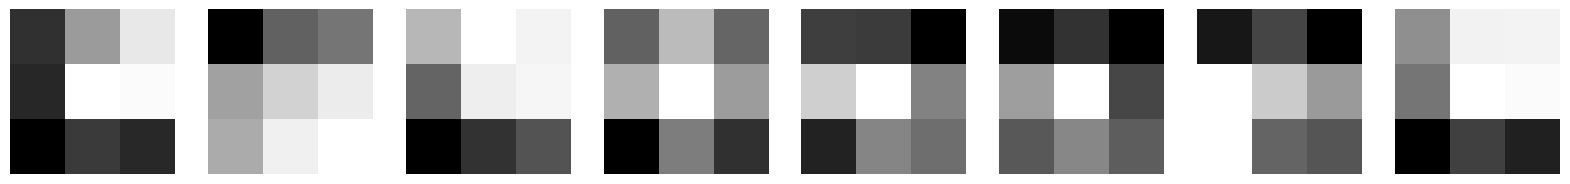

In [19]:
def visualize_filters(W1):
    num_filters = W1.shape[-1]
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 20))
    for i in range(num_filters):
        axes[i].imshow(W1[:, :, :, i], cmap='gray')
        axes[i].axis('off')
    plt.show()

visualize_filters(W1)

## Task 10: Evaluate the Model on Test Data

Evaluate the model on the test data and compute the accuracy.

In [20]:
def evaluate_model(x_test, y_test, params):
    num_correct = 0
    for i in range(len(x_test)):
        X = x_test[i]
        y = np.argmax(y_test[i])
        _, _, _, _, _, _, _, A3 = forward_propagation(X, params)
        if np.argmax(A3) == y:
            num_correct += 1
    accuracy = num_correct / len(x_test)
    return accuracy

accuracy = evaluate_model(x_test, y_test, params)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

<ipython-input-2-89709a2af507>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[h, w, c] = np.sum(X_slice * W[:, :, :, c]) + b[:, :, :, c]


Test Accuracy: 62.50%
